**PART 3: SGD**

Importing Libraries

In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.linalg import norm 
from sklearn.model_selection import train_test_split
from scipy.linalg import svdvals
from scipy.optimize import fmin_l_bfgs_b
from math import sqrt
from matplotlib.pyplot import figure
#figure(figsize=(10, 5), dpi=80)

Loading and cleaning the dataset

In [ ]:
data=pd.read_csv('energy.csv')
data_copy=data.copy()
A = data_copy[['Relative_Compactness', 'Surface_Area', 'Wall_Area', 'Roof_Area','Overall_Height', 'Orientation', 'Glazing_Area','Glazing_Area_Distribution']]
y=data_copy[['Heating_Load']]

In [ ]:
m=A.mean(axis=0)
s=A.std(axis=0)
my=y.mean()

A=(A-m)/s
y=y-my

n=A.shape[0]
d=A.shape[1]

A_mat=A.to_numpy()
y_mat=y.to_numpy().reshape(n)

Useful functions and classes (as introduced during the practical session):

In [ ]:
# Python class for regression problems
class RegPb(object):
   
    # Instantiate the class
    def __init__(self, A, y,lbda=0,loss='l2'):
        self.A = A
        self.y = y
        self.n, self.d = A.shape
        self.loss = loss
        self.lbda = lbda
        
    
    # Objective value
    def fun(self, x):
        if self.loss=='l2':
            return norm(self.A.dot(x) - self.y) ** 2 / (2. * self.n) + self.lbda * norm(x) ** 2 / 2.
        elif self.loss=='logit':
            yAx = self.y * self.A.dot(x)
            return np.mean(np.log(1. + np.exp(-yAx))) + self.lbda * norm(x) ** 2 / 2.
    
    # Partial objective value
    def f_i(self, i, x):
        if self.loss=='l2':
            return norm(self.A[i].dot(x) - self.y[i]) ** 2 / (2.) + self.lbda * norm(x) ** 2 / 2.
        elif self.loss=='logit':
            yAxi = self.y[i] * np.dot(self.A[i], x)
            return np.log(1. + np.exp(- yAxi)) + self.lbda * norm(x) ** 2 / 2.
    
    # Full gradient computation
    def grad(self, x):
        if self.loss=='l2':
            return self.A.T.dot(self.A.dot(x) - self.y) / self.n + self.lbda * x
        elif self.loss=='logit':
            yAx = self.y * self.A.dot(x)
            aux = 1. / (1. + np.exp(yAx))
            return - (self.A.T).dot(self.y * aux) / self.n + self.lbda * x
    
    # Partial gradient
    def grad_i(self,i,x):
        a_i = self.A[i]
        if self.loss=='l2':
            return (a_i.dot(x) - self.y[i]) * a_i + self.lbda*x
        elif self.loss=='logit':
            grad = - a_i * self.y[i] / (1. + np.exp(self.y[i]* a_i.dot(x)))
            grad += self.lbda * x
            return grad
        
    # Partial gradient knowing the model (useful for certain gradient techniques)
    def grad_ai(self,i,aix,x=None):
        a_i = self.A[i]
        if self.loss=='l2':
            grad = (aix - self.y[i]) * a_i 
            if (self.lbda>0):
                grad += self.lbda*x
        elif self.loss=='logit':
            grad = - a_i * self.y[i] / (1. + np.exp(self.y[i]* aix))
            if (self.lbda>0):
                grad += self.lbda * x
        return grad        

    # Lipschitz constant for the gradient
    def lipgrad(self):
        if self.loss=='l2':
            L = norm(self.A, ord=2) ** 2 / self.n + self.lbda
        elif self.loss=='logit':
            L = norm(self.A, ord=2) ** 2 / (4. * self.n) + self.lbda
        return L
    
    # ''Strong'' convexity constant (could be zero if self.lbda=0)
    def cvxval(self):
        if self.loss=='l2':
            s = svdvals(self.A)
            mu = min(s)**2 / self.n 
            return mu + self.lbda
        elif self.loss=='logit':
            return self.lbda

In [ ]:
# Stochastic gradient implementation
def stoch_grad(x0,problem,xtarget,stepchoice=0,step0=1, n_iter=1000,nb=1,average=0,scaling=0,with_replace=False,verbose=False): 

    ############
    # Initial step: Compute and plot some initial quantities

    # objective history
    objvals = []
    
    # iterates distance to the minimum history
    normits = []
    
    # Lipschitz constant
    L = problem.lipgrad()
    
    # Number of samples
    n = problem.n
    d = problem.d
    
    # Initial value of current iterate  
    x = x0.copy()
    nx = norm(x)
    
    # Average (if needed)
    if average:
            xavg=np.zeros(len(x))
    
    #Scaling values
    if scaling>0:
        mu=1/(2 *(n ** (0.5)))
        v = np.zeros(d)
        beta = 0.8

    # Initialize iteration counter
    k=0
    
    # Current objective
    obj = problem.fun(x) 
    objvals.append(obj);
    # Current distance to the optimum
    nmin = norm(x-xtarget)
    normits.append(nmin)
    
    # Plot initial quantities of interest
    if verbose:
        print("Stochastic Gradient, batch size=",nb,"/",n)
        print(' | '.join([name.center(8) for name in ["iter", "fval", "normit"]]))
        print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % nmin).rjust(8)]))
    
    ################
    # Main loop
    while (k < n_iter and nx < 10**100):
        # Draw the batch indices
        ik = np.random.choice(n,nb,replace=with_replace)# Batch gradient
        # Stochastic gradient calculation
        sg = np.zeros(d)
        for j in range(nb):
            gi = problem.grad_i(ik[j],x)
            sg = sg + gi
        sg = (1/nb)*sg
        
        if scaling>0:
            if scaling==1:
                # RMSProp update
                v = beta*v + (1-beta)*sg*sg
            elif scaling==2:
                # Adagrad update
                v = v + sg*sg 
            sg = sg/(np.sqrt(v+mu))
            
        if stepchoice==0:
            x[:] = x - (1/L) * sg
        elif stepchoice==1:
            sk = float(step0/(sqrt(k+1)))
            x[:] = x - sk * sg
        
        nx = norm(x) #Computing the norm to measure divergence 
        
        if average:
            # If average, compute the average of the iterates
            xavg = k/(k+1) *xavg + x/(k+1) 
            nmin = norm(xavg-xtarget)
            obj = problem.fun(xavg)
        else:
            obj = problem.fun(x)
            nmin = norm(x-xtarget)
        
       
        
        k += 1
        # Plot quantities of interest at the end of every epoch only
        if (k*nb) % n == 0:
            objvals.append(obj)
            normits.append(nmin)
            if verbose:
                print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % nmin).rjust(8)]))     
    
    # End of main loop
    #################
    
    # Plot quantities of interest for the last iterate (if needed)
    if (k*nb) % n > 0:
        objvals.append(obj)
        normits.append(nmin)
        if verbose:
            print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % nmin).rjust(8)]))              
    
    # Outputs
    if average:
        x_output = xavg.copy()
    else:
        x_output = x.copy()
    
    return x_output, np.array(objvals), np.array(normits)

In [ ]:
# Implementation - Stochastic Variance Reduced Gradient
def svrg(x0,problem,xtarget,n_iter=1000,m=5,verbose=False): 
    """
        A code for stochastic variance reduced gradient (SVRG).
        
        Inputs:
            x0: Initial vector
            problem: Problem structure
                problem.fun() returns the objective function, which is assumed to be a finite sum of functions
                problem.n returns the number of components in the finite sum
                problem.grad_i() returns the gradient of a single component f_i
                problem.lipgrad() returns the Lipschitz constant for the gradient
                problem.cvxval() returns the strong convexity constant
                problem.lambda returns the value of the regularization parameter
            xtarget: Target minimum (unknown in practice!)
            stepchoice: Strategy for computing the stepsize 
                0: Constant step size equal to 1/L
                1: Step size decreasing in 1/sqrt(k+1)
            step0: Initial steplength (only used when stepchoice is not 0)
            n_iter: Number of iterations, used as stopping criterion
            m: length of the inner iteration loop
            verbose: Plot quantities of interest if set to True (default: False)
            
            
        Outputs:
            x_output: Final iterate of the method
            objgap: History of function values (Numpy array of length n_iter at most)
            normits: History of distances between iterates and optimum (Numpy array of length n_iter at most)
    """
    ############
    # Initial step: Compute and plot some initial quantities

    # objective history
    objvals = []
    # iterates distance to the minimum history
    normits = []
    
    # Lipschitz constant
    L = problem.lipgrad()
    
    mu = problem.cvxval()
    
    # Number of samples
    n = problem.n
    
    alpha = 0.2/L
    
    
    # Initial value of current iterate  
    x = x0.copy()
    nx = norm(x)

    # Initialize iteration counter
    k=0
    
    # Current objective
    obj = problem.fun(x) 
    objvals.append(obj);
    # Current distance to the optimum
    nmin = norm(x-xtarget)
    normits.append(nmin)
    
    # Plot initial quantities of interest
    if verbose:
        print("SVRG")
        print(' | '.join([name.center(8) for name in ["iter", "fval", "normit"]]))
        print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % nmin).rjust(8)]))
    
    ################
    # Main loop
    while (k < n_iter and nx < 10**100):
        
        # Compute a full gradient at the beginning of every major iteration
        gxk = problem.grad(x)
        if (k+n)//n > k//n:
            objvals.append(obj)
            normits.append(nmin)
            if verbose:
                print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % nmin).rjust(8)])) 
        
        
        xtilda = x
        xtildavg = x
        
        ######
        # Inner loop
        for j in range(m):
            ij = np.random.choice(n,1,replace=True)
            sg = problem.grad_i(ij[0],xtilda)-problem.grad_i(ij[0],x)+gxk
            xtilda[:] = xtilda - alpha*sg 
            
            if (k+n+j)//n > (k+n)//n:
                objvals.append(obj)
                normits.append(nmin)
                if verbose:
                    print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % nmin).rjust(8)]))  
        # End inner loop
        ######

        x[:] = xtilda.copy()
        nx = norm(x) #Computing the norm to measure divergence 
        obj = problem.fun(x)
        nmin = norm(x-xtarget)
        k += 1
        # Plot quantities of interest at the end of every epoch only
        if k+m+n % n == 0:
            objvals.append(obj)
            normits.append(nmin)
            if verbose:
                print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % nmin).rjust(8)]))       
    
    # End of main loop
    #################
    
    # Plot quantities of interest for the last iterate (if needed)
    if k+m+n % n > 0:
        objvals.append(obj)
        normits.append(nmin)
        if verbose:
            print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % nmin).rjust(8)]))              
    
    # Outputs
    x_output = x.copy()
    return x_output, np.array(objvals), np.array(normits)

In [ ]:
#instantiating a regression problem, no ridge penalty
x_init = np.zeros(d)
lbda = 0
pblinreg = RegPb(A_mat, y_mat,lbda,loss='l2')

#Using L-BFGS-B algorithm to determine a solution

x_min_lin, f_min_lin, _ = fmin_l_bfgs_b(pblinreg.fun, x_init, pblinreg.grad, args=(), pgtol=1e-30, factr =1e-30)

# Compute the optimal solution for linear regression
x_min_lin, f_min_lin, _ = fmin_l_bfgs_b(pblinreg.fun, x_init, pblinreg.grad, args=(), pgtol=1e-30, factr =1e-30)
print(f_min_lin)
print(norm(pblinreg.grad(x_min_lin)))

4.260264443454086
1.4138666891417796e-09


***Question 1***

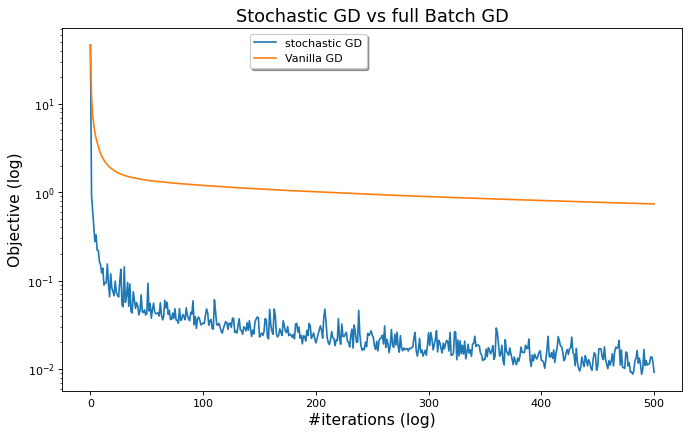

In [ ]:
nb_epochs = 500
n = pblinreg.n
nbset = n
x0 = np.zeros(d)


plt.figure(figsize=(10, 6),dpi=80)
plt.set_cmap("RdPu")
plt.title("Stochastic GD vs full Batch GD", fontsize=16)


_, objs1, _ = stoch_grad(x0,pblinreg,x_min_lin,stepchoice=1,step0=0.2, n_iter=int(nb_epochs*n),nb=1,verbose=False,with_replace=True)
_, objs2, _ = stoch_grad(x0,pblinreg,x_min_lin,stepchoice=1,step0=0.2, n_iter=int(nb_epochs),nb=n,verbose=False,with_replace=True)

plt.semilogy(objs1-f_min_lin, label="stochastic GD")
plt.semilogy(objs2-f_min_lin, label="Vanilla GD")

plt.xlabel("#iterations (log)", fontsize=14)
plt.ylabel("Objective (log)", fontsize=14)
plt.legend(loc='best', bbox_to_anchor=(0.5, 1.0),
          ncol=1, fancybox=True, shadow=True);

**Question 2**

Here, we aim to plot Stochastic GD with different sizes of the batch ranging from 1 (SGD) to n (Batch GD) to find the best mini-batch for our problem

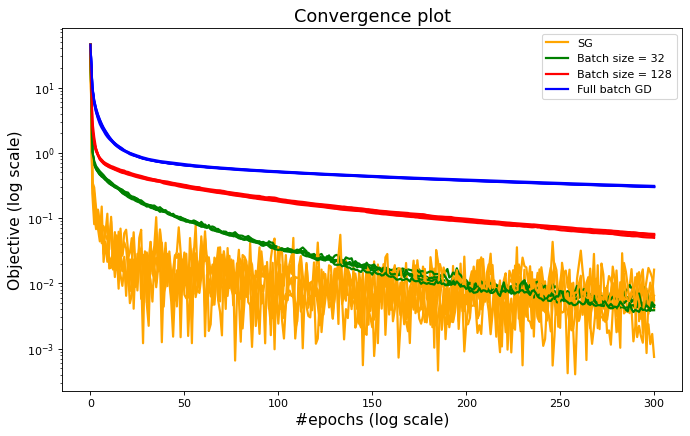

In [ ]:
x_init = np.zeros(d)
lbda = 1. / n ** (0.5)
pblinreg = RegPb(A_mat, y_mat,lbda,loss='l2')
x_min_lin, f_min_lin, _ = fmin_l_bfgs_b(pblinreg.fun, x_init, pblinreg.grad, args=(), pgtol=1e-30, factr =1e-30)

nb_epochs = 300
n = pblinreg.n
x0 = np.zeros(d)


plt.figure(figsize=(10, 6),dpi=80)

nruns = 5
sp=1 #stepchoise
s=0.2 #step
for i in range(nruns):
    # Run standard stochastic gradient (batch size 1)
    _, obj_a, _ = stoch_grad(x0,pblinreg,x_min_lin,stepchoice=sp,step0=s, n_iter=nb_epochs*n,nb=1,with_replace=True)
    # Batch stochastic gradient (batch size n/24)
    nbset=int(n/24)
    _, obj_b, _ = stoch_grad(x0,pblinreg,x_min_lin,stepchoice=sp,step0=s, n_iter=int(nb_epochs*n/nbset),nb=nbset,with_replace=True)
    # Batch stochastic gradient (batch size n/6)
    nbset=int(n/6)
    _, obj_c, _ = stoch_grad(x0,pblinreg,x_min_lin,stepchoice=sp,step0=s, n_iter=int(nb_epochs*n/nbset),nb=nbset,with_replace=True)
    # Batch stochastic gradient (batch size n/192)
    #nbset=int(n/96)
    #_, obj_f, _ = stoch_grad(x0,pblinreg,x_min_lin,stepchoice=sp,step0=s, n_iter=int(nb_epochs*n/nbset),nb=nbset,with_replace=True)    
    # Batch stochastic gradient (batch size n, with replacement)
    nbset=n
    _, obj_d, _ = stoch_grad(x0,pblinreg,x_min_lin,stepchoice=sp,step0=s, n_iter=int(nb_epochs*n/nbset),nb=nbset,with_replace=True)
    if i<nruns-1:
        plt.semilogy(obj_a-f_min_lin,color='orange',lw=2)
        plt.semilogy(obj_b-f_min_lin,color='green', lw=2)
        #plt.semilogy(obj_f-f_min_lin, lw=2)
        plt.semilogy(obj_c-f_min_lin,color='red', lw=2)
        plt.semilogy(obj_d-f_min_lin,color='blue', lw=2)
plt.semilogy(obj_a-f_min_lin,label="SG",color='orange',lw=2)
#plt.semilogy(obj_f-f_min_lin,label="batch n/192",lw=2)
plt.semilogy(obj_b-f_min_lin,label="Batch size = 32",color='green',lw=2)
plt.semilogy(obj_c-f_min_lin,label="Batch size = 128",color='red', lw=2)
plt.semilogy(obj_d-f_min_lin,label="Full batch GD",color='blue', lw=2)    

plt.title("Convergence plot", fontsize=16)
plt.xlabel("#epochs (log scale)", fontsize=14)
plt.ylabel("Objective (log scale)", fontsize=14)
plt.legend()

Using a mini-batch of size 32 seems to be a good compromise between SGD and batch GD.

**Question 3**

In this part, I compared SGD with the Stochastic Variance Reduced Gradient algorithm.


<Figure size 800x480 with 0 Axes>

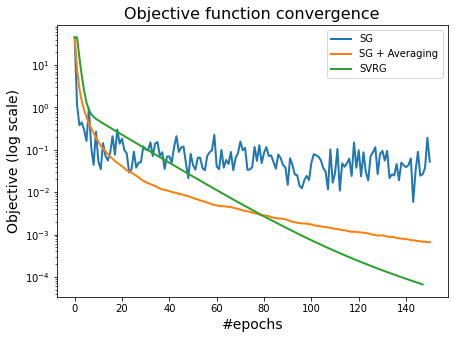

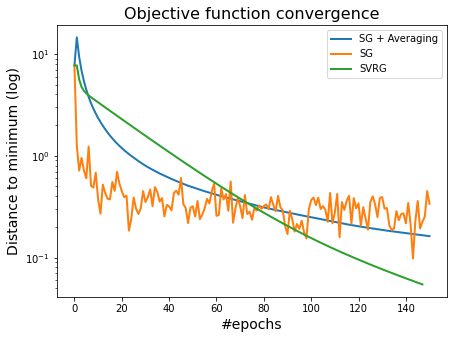

In [ ]:
x_init = np.zeros(d)
lbda = 1. / n ** (0.5)
pblinreg = RegPb(A_mat, y_mat,lbda,loss='l2')
x_min_lin, f_min_lin, _ = fmin_l_bfgs_b(pblinreg.fun, x_init, pblinreg.grad, args=(), pgtol=1e-30, factr =1e-30)

nb_epochs = 150
n = pblinreg.n
x0 = np.zeros(d)
m = 8

plt.figure(figsize=(10, 6),dpi=80)


# Stochastic gradient (batch size 1) with averaging
x_a, obj_a, nits_a = stoch_grad(x0,pblinreg,x_min_lin,stepchoice=1,step0=1, n_iter=nb_epochs*n,nb=1,with_replace=True, average=1)
# Stochastic gradient (batch size 1) without averaging
x_c, obj_c, nits_c = stoch_grad(x0,pblinreg,x_min_lin,stepchoice=1,step0=1, n_iter=nb_epochs*n,nb=1,with_replace=True, average=0)
# SVRG
x_b, obj_b, nits_b = svrg(x0,pblinreg,x_min_lin,n_iter=int(nb_epochs*n/(2*m+n)),m=m)

# Plot the results
# In terms of objective value (logarithmic scale)
plt.figure(figsize=(7, 5))
plt.semilogy(obj_c-f_min_lin, label="SG", lw=2)
plt.semilogy(obj_a-f_min_lin, label="SG + Averaging", lw=2)
plt.semilogy(obj_b-f_min_lin, label="SVRG", lw=2)

plt.title("Objective function convergence", fontsize=16)
plt.xlabel("#epochs", fontsize=14)
plt.ylabel("Objective (log scale)", fontsize=14)
plt.legend()
# In terms of gradient norm (logarithmic scale)
plt.figure(figsize=(7, 5))
plt.semilogy(nits_a, label="SG + Averaging", lw=2)
plt.semilogy(nits_c, label="SG", lw=2)
plt.semilogy(nits_b, label="SVRG", lw=2)

plt.title("Objective function convergence", fontsize=16)
plt.xlabel("#epochs", fontsize=14)
plt.ylabel("Distance to minimum (log)", fontsize=14)
plt.legend();